# Cleaning FB data

In this notebook I'll take the information retrieved from Facebook to costruct a possible dataframe for my model, that takes in account the reactions of the previous days.

In [ ]:
import pandas as pd

In [7]:
df_ts = pd.read_csv("../scrapers/facebook/my_scraper/timestamps/Arsenal_timestamp.csv")
df_reactions = pd.read_csv("../scrapers/facebook/my_scraper/data_reaction/Arsenal_reactions.csv")

In [8]:
df_ts.head()

,post_id,timestamp
0,10157937496102713,1587985200
1,10157962669277713,1587972648
2,10157962642577713,1587967222
3,10157874177792713,1587906030
4,10157960126502713,1587901212


In [9]:
df_reactions.head()

,post_id,like,love,wow,haha,sorry,anger
0,10157937496102713,6297,668,15,12,0,0
1,10157962669277713,34092,3824,33,79,8,4
2,10157962642577713,18609,1952,22,24,1,4
3,10157874177792713,932,57,1,9,1,4
4,10157960126502713,36758,4077,77,134,9,18


In [10]:
df_ts.post_id = df_ts.post_id.astype(str) 
df_reactions.post_id = df_reactions.post_id.astype(str) 

In [11]:
merged = pd.merge(df_ts, df_reactions, how="left", on="post_id")

In [12]:
merged.head()

,post_id,timestamp,like,love,wow,haha,sorry,anger
0,10157937496102713,1587985200,6297,668,15,12,0,0
1,10157962669277713,1587972648,34092,3824,33,79,8,4
2,10157962642577713,1587967222,18609,1952,22,24,1,4
3,10157874177792713,1587906030,932,57,1,9,1,4
4,10157960126502713,1587901212,36758,4077,77,134,9,18


In [13]:
from datetime import datetime
to_date = []
for t in merged.timestamp:
    to_date.append(datetime.fromtimestamp(t))

In [14]:
merged['time'] = to_date

In [15]:
merged.head(10)

,post_id,timestamp,like,love,wow,haha,sorry,anger,time
0,10157937496102713,1587985200,6297,668,15,12,0,0,2020-04-27 13:00:00
1,10157962669277713,1587972648,34092,3824,33,79,8,4,2020-04-27 09:30:48
2,10157962642577713,1587967222,18609,1952,22,24,1,4,2020-04-27 08:00:22
3,10157874177792713,1587906030,932,57,1,9,1,4,2020-04-26 15:00:30
4,10157960126502713,1587901212,36758,4077,77,134,9,18,2020-04-26 13:40:12
5,10157958171952713,1587888055,66652,6771,52,1114,18,12,2020-04-26 10:00:55
6,10157958110667713,1587880800,53588,13673,686,317,13,8,2020-04-26 08:00:00
7,10157957340642713,1587846625,14482,628,26,2979,11,9,2020-04-25 22:30:25
8,10157956942937713,1587843022,16149,2162,22,177,2,2,2020-04-25 21:30:22
9,10157956888057713,1587838638,14515,1653,24,12,53,1,2020-04-25 20:17:18


In [16]:
def transform_df(df, start_date_str, end_date_str, normalize=False):
    
    def normalize(v):
        res_vec = []
        vec_min, vec_max = min(v), max(v)
        den = vec_max-vec_min
        for el in v:
            res_vec.append((el-vec_min)/den)
        return res_vec
    
    new_df = df[['time','like','love','wow','haha','sorry','anger']]
    ind = []
    for i,x in zip(new_df.index, new_df.time):
        if len(str(x)) < 4: #remove missing dates
            ind.append(i)
    new_df=new_df.drop(ind).reset_index(drop=True)
    day = []
    for x in new_df['time']:
        d = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
        day.append(d)
    new_df['day'] = day
    new_df = new_df.drop(['time'], axis=1).sort_values(by=['day']).reset_index(drop=True)
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d %H:%M:%S')
    new_df = new_df[(new_df.day>start_date) & (new_df.day<end_date)].reset_index(drop=True)
    new_df.day = new_df.day.astype(str) # cast to str to split
    new_df['day'] = [x[0] for x in new_df.day.str.split(' ')]
    new_df = pd.DataFrame(new_df.groupby(['day']).sum())
    if normalize==True:
        new_df.like = normalize(new_df.like)
        new_df.love = normalize(new_df.love)
        new_df.wow = normalize(new_df.wow)
        new_df.haha = normalize(new_df.haha)
        new_df.sorry = normalize(new_df.sorry)
        new_df.anger = normalize(new_df.anger)
    return new_df

In [17]:
start_date = '2018-08-07 13:55:26'
end_date = '2019-05-20 13:55:26'
res = transform_df(merged, start_date, end_date)

In [18]:
res

,like,love,wow,haha,sorry,anger
day,,,,,,
2018-08-07,11194,537,16,742,2,1
2018-08-08,12713,602,71,20,2,2
2018-08-09,21650,1781,170,1166,10,18
2018-08-10,11264,831,24,177,1,1
2018-08-11,10470,745,56,13,0,1
2018-08-12,6501,1148,49,29,5,4
2018-08-14,45165,3816,140,108,204,23
2018-08-16,14370,793,37,246,25,211
2018-08-17,45038,6188,295,49,48,9


In [19]:
for i,m in zip(merged.post_id, merged.time):
    if str(m).startswith('2019-05-01'):
        print(i)

10156828716337713
10156828386692713


In [20]:
merged[merged.post_id=='10156828716337713']

,post_id,timestamp,like,love,wow,haha,sorry,anger,time
872,10156828716337713,1556729338,73954,12690,127,291,10774,93,2019-05-01 18:48:58


In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 10))
plt.xticks(rotation=90)
plt.plot(res.index, res.love, marker='o', linewidth=2, markersize=0, color='b')
# plt.plot(res.index, res.like, marker='o', linewidth=2, markersize=0, color='r')
# plt.plot(res.index, res.wow, marker='o', linewidth=2, markersize=0, color='y')
# plt.plot(res.index, res.sorry, marker='o', linewidth=2, markersize=0, color='g')
# plt.plot(res.day, res.like_y, marker='o', linewidth=2, markersize=0, color='r')
# plt.plot(x.index, x.sorry, marker='o', linewidth=2, markersize=0, color='r')
# plt.plot(x.index, x.love, marker='o', linewidth=2, markersize=0, color='b')
# plt.plot(x.index, x.wow, marker='o', linewidth=2, markersize=0, color='y')
plt.show()

<Figure size 4000x1000 with 1 Axes>

In [22]:
import numpy as np
from scipy import stats
res_wo_outliers = res[(np.abs(stats.zscore(res)) < 3).all(axis=1)]

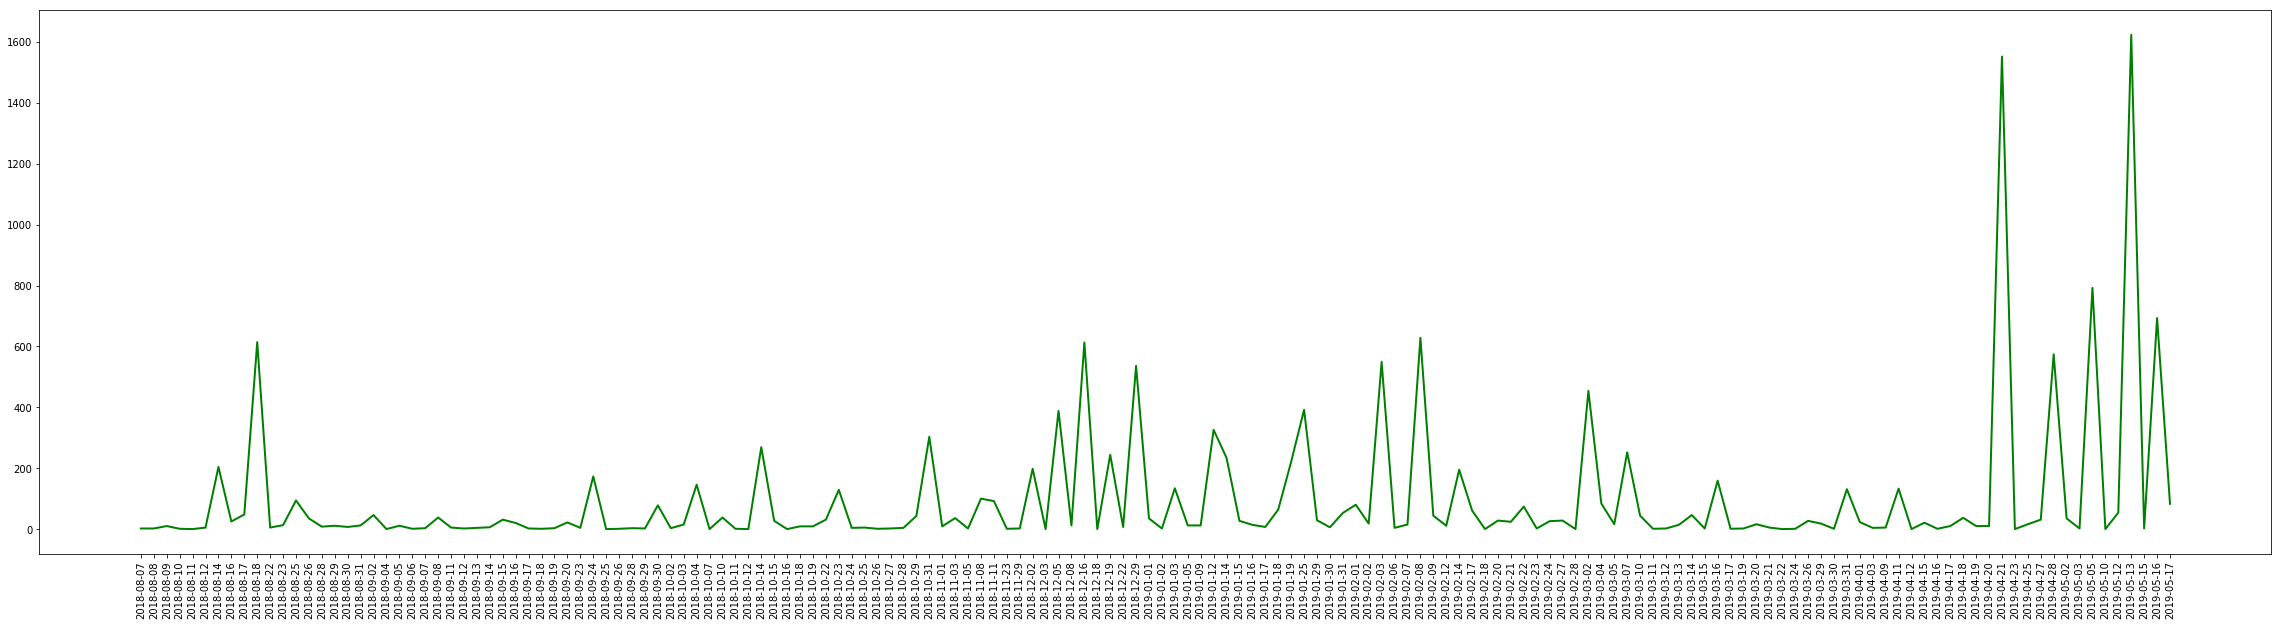

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 10))
plt.xticks(rotation=90)
# plt.plot(res_wo_outliers.index, res_wo_outliers.love, marker='o', linewidth=2, markersize=0, color='b')
# plt.plot(res_wo_outliers.index, res_wo_outliers.like, marker='o', linewidth=2, markersize=0, color='r')
# plt.plot(res_wo_outliers.index, res_wo_outliers.wow, marker='o', linewidth=2, markersize=0, color='y')
plt.plot(res_wo_outliers.index, res_wo_outliers.sorry, marker='o', linewidth=2, markersize=0, color='g')
# plt.plot(res.day, res.like_y, marker='o', linewidth=2, markersize=0, color='r')
# plt.plot(x.index, x.sorry, marker='o', linewidth=2, markersize=0, color='r')
# plt.plot(x.index, x.love, marker='o', linewidth=2, markersize=0, color='b')
# plt.plot(x.index, x.wow, marker='o', linewidth=2, markersize=0, color='y')
plt.show()

# Ora proviamo a mettere insieme alle partite

In [24]:
calendar = pd.read_csv("../dataset/premier/original/1/premier_1819_1.csv")
calendar.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


In [25]:
calendar = calendar[['Date','HomeTeam','AwayTeam','FTHG','FTAG']]
calendar.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,10/08/2018,Man United,Leicester,2,1
1,11/08/2018,Bournemouth,Cardiff,2,0
2,11/08/2018,Fulham,Crystal Palace,0,2
3,11/08/2018,Huddersfield,Chelsea,0,3
4,11/08/2018,Newcastle,Tottenham,1,2


In [26]:
team_game_inds = []
for ind, ht, at in zip(calendar.index, calendar.HomeTeam, calendar.AwayTeam):
    if ht=="Arsenal" or at=="Arsenal":
        team_game_inds.append(ind)

In [27]:
team_game_df = calendar.loc[team_game_inds].reset_index(drop=True)
team_game_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,12/08/2018,Arsenal,Man City,0,2
1,18/08/2018,Chelsea,Arsenal,3,2
2,25/08/2018,Arsenal,West Ham,3,1
3,02/09/2018,Cardiff,Arsenal,2,3
4,15/09/2018,Newcastle,Arsenal,1,2
5,23/09/2018,Arsenal,Everton,2,0
6,29/09/2018,Arsenal,Watford,2,0
7,07/10/2018,Fulham,Arsenal,1,5
8,22/10/2018,Arsenal,Leicester,3,1
9,28/10/2018,Crystal Palace,Arsenal,2,2


In [28]:
from datetime import date, timedelta
new_col_like = []
new_col_love = []
new_col_wow = []
new_col_sorry = []
new_col_anger = []
new_col_haha = []
for d in team_game_df.Date:
    day, month, year = map(int, d.split("/"))
    tmp_like, tmp_love, tmp_sorry, tmp_anger, tmp_wow, tmp_haha = 0,0,0,0,0,0
    for i in range(7):
        try:
            md = date(year, month, day)
            tmp = res.loc[f"{(md - timedelta(days=i+1)).isoformat()}"]
            tmp_like+=tmp['like']
            tmp_love+=tmp['love']
            tmp_wow+=tmp['wow']
            tmp_sorry+=tmp['sorry']
            tmp_haha+=tmp['haha']
            tmp_anger+=tmp['anger']
        except KeyError:
#             print(f"Error for date {(md - timedelta(days=i+1)).isoformat()}")
            pass
    new_col_like.append(tmp_like)
    new_col_love.append(tmp_love)
    new_col_wow.append(tmp_wow)
    new_col_sorry.append(tmp_sorry)
    new_col_anger.append(tmp_haha)
    new_col_haha.append(tmp_anger)

In [29]:
new_df = team_game_df.copy()
new_df["1_day_before_like"] = new_col_like
new_df["1_day_before_love"] = new_col_love
new_df["1_day_before_wow"] = new_col_wow
new_df["1_day_before_sorry"] = new_col_sorry
new_df["1_day_before_anger"] = new_col_anger
new_df["1_day_before_haha"] = new_col_haha

In [30]:
new_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,1_day_before_like,1_day_before_love,1_day_before_wow,1_day_before_sorry,1_day_before_anger,1_day_before_haha
0,12/08/2018,Arsenal,Man City,0,2,67291,4496,337,15,2118,23
1,18/08/2018,Chelsea,Arsenal,3,2,121544,12690,577,282,445,248
2,25/08/2018,Arsenal,West Ham,3,1,72736,4272,471,632,2888,2205
3,02/09/2018,Cardiff,Arsenal,2,3,170809,7224,536,73,8441,87
4,15/09/2018,Newcastle,Arsenal,1,2,174287,8781,658,55,1383,47
5,23/09/2018,Arsenal,Everton,2,0,67202,5698,226,48,266,79
6,29/09/2018,Arsenal,Watford,2,0,186226,14365,1006,181,1717,125
7,07/10/2018,Fulham,Arsenal,1,5,259121,13540,1614,242,1657,808
8,22/10/2018,Arsenal,Leicester,3,1,262289,17939,2514,45,802,23
9,28/10/2018,Crystal Palace,Arsenal,2,2,375408,12806,809,172,3803,47


In [88]:
from datetime import datetime, date, timedelta

def add_date(merged: pd.DataFrame) -> pd.DataFrame:
    to_date = []
    for t in merged.timestamp:
        if t!=-1:
            to_date.append(datetime.fromtimestamp(t))
        else:
            to_date.append(-1)
    merged['time'] = to_date
    return merged

def get_team_calendar(team_name: str, filename="../dataset/premier/original/1/premier_1819_1.csv") -> pd.DataFrame:
    calendar = pd.read_csv(filename)
    calendar = calendar[['Date','HomeTeam','AwayTeam','FTHG','FTAG']]
    # get only team matches
    team_game_inds = []
    for ind, ht, at in zip(calendar.index, calendar.HomeTeam, calendar.AwayTeam):
        if ht==team_name or at==team_name:
            team_game_inds.append(ind)
    team_game_df = calendar.loc[team_game_inds].reset_index(drop=True)
    return team_game_df

def add_reactions(team_game_df, res,n_days_before):
    new_col_like = []
    new_col_love = []
    new_col_wow = []
    new_col_sorry = []
    new_col_anger = []
    new_col_haha = []
    for d in team_game_df.Date:
        day, month, year = map(int, d.split("/"))
        tmp_like, tmp_love, tmp_sorry, tmp_anger, tmp_wow, tmp_haha = 0,0,0,0,0,0
        for i in range(n_days_before):
            try:
                md = date(year, month, day)
                tmp = res.loc[f"{(md - timedelta(days=i+1)).isoformat()}"]
                tmp_like+=tmp['like']
                tmp_love+=tmp['love']
                tmp_wow+=tmp['wow']
                tmp_sorry+=tmp['sorry']
                tmp_haha+=tmp['haha']
                tmp_anger+=tmp['anger']
            except KeyError:
    #             print(f"Error for date {(md - timedelta(days=i+1)).isoformat()}")
                pass
        new_col_like.append(tmp_like)
        new_col_love.append(tmp_love)
        new_col_wow.append(tmp_wow)
        new_col_sorry.append(tmp_sorry)
        new_col_anger.append(tmp_haha)
        new_col_haha.append(tmp_anger)
    new_df = team_game_df.copy()
    new_df[f"{n_days_before}_day_before_like"] = new_col_like
    new_df[f"{n_days_before}_day_before_love"] = new_col_love
    new_df[f"{n_days_before}_day_before_wow"] = new_col_wow
    new_df[f"{n_days_before}_day_before_sorry"] = new_col_sorry
    new_df[f"{n_days_before}_day_before_anger"] = new_col_anger
    new_df[f"{n_days_before}_day_before_haha"] = new_col_haha
    return new_df

def transform_df(df, start_date_str, end_date_str, normalize=False):
    
    def normalize(v):
        res_vec = []
        vec_min, vec_max = min(v), max(v)
        den = vec_max-vec_min
        for el in v:
            res_vec.append((el-vec_min)/den)
        return res_vec

    new_df = df[['time','like','love','wow','haha','sorry','anger']]
    ind = []
    for i,x in zip(new_df.index, new_df.time):
        if len(str(x)) < 4: #remove missing dates
            ind.append(i)
    new_df=new_df.drop(ind).reset_index(drop=True)
    day = []
    for x in new_df['time']:
        d = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
        day.append(d)
    new_df['day'] = day
    new_df = new_df.drop(['time'], axis=1).sort_values(by=['day']).reset_index(drop=True)
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d %H:%M:%S')
    new_df = new_df[(new_df.day>start_date) & (new_df.day<end_date)].reset_index(drop=True)
    new_df.day = new_df.day.astype(str) # cast to str to split
    new_df['day'] = [x[0] for x in new_df.day.str.split(' ')]
    new_df = pd.DataFrame(new_df.groupby(['day']).sum())
    if normalize==True:
        new_df.like = normalize(new_df.like)
        new_df.love = normalize(new_df.love)
        new_df.wow = normalize(new_df.wow)
        new_df.haha = normalize(new_df.haha)
        new_df.sorry = normalize(new_df.sorry)
        new_df.anger = normalize(new_df.anger)
    return new_df

def create_reactions_ready_df(_df_ts: pd.DataFrame, _df_reactions: pd.DataFrame, team_name: str, start_date_str: str, end_date_str: str, n_days_before=7) -> pd.DataFrame:
    # first make sure to read ids as str
    _df_ts.post_id = _df_ts.post_id.astype(str) 
    _df_reactions.post_id = _df_reactions.post_id.astype(str) 
    # merge dataframes
    merged = pd.merge(_df_ts, _df_reactions, how="left", on="post_id")
    merged = add_date(merged)
    res = transform_df(merged, start_date, end_date)
    # now get the calendar for that team
    team_calendar = get_team_calendar(team_name)
    final_df = add_reactions(team_calendar, res, n_days_before)
    final_df['team'] = team_name
    return final_df

In [89]:
df_ts_1 = pd.read_csv("../scrapers/facebook/my_scraper/timestamps/ChelseaFC_timestamp.csv")
df_reactions_1 = pd.read_csv("../scrapers/facebook/my_scraper/data_reaction/ChelseaFC_reactions.csv")
tn = "Chelsea"
start_date = '2018-08-07 13:55:26'
end_date = '2019-05-20 13:55:26'

In [90]:
create_reactions_ready_df(df_ts_1, df_reactions_1, tn, start_date, end_date, 7)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,7_day_before_like,7_day_before_love,7_day_before_wow,7_day_before_sorry,7_day_before_anger,7_day_before_haha,team
0,11/08/2018,Huddersfield,Chelsea,0,3,129609,13995,669,79,3171,124,Chelsea
1,18/08/2018,Chelsea,Arsenal,3,2,143974,9188,999,37,210,27,Chelsea
2,26/08/2018,Newcastle,Chelsea,1,2,196983,13294,884,73,692,137,Chelsea
3,01/09/2018,Chelsea,Bournemouth,2,0,256841,11863,1101,480,916,124,Chelsea
4,15/09/2018,Chelsea,Cardiff,4,1,75530,3355,310,25,219,39,Chelsea
5,23/09/2018,West Ham,Chelsea,0,0,61190,4774,293,13,194,11,Chelsea
6,29/09/2018,Chelsea,Liverpool,1,1,311479,47912,12937,162,2092,123,Chelsea
7,07/10/2018,Southampton,Chelsea,0,3,0,0,0,0,0,0,Chelsea
8,20/10/2018,Chelsea,Man United,2,2,0,0,0,0,0,0,Chelsea
9,28/10/2018,Burnley,Chelsea,0,4,0,0,0,0,0,0,Chelsea


# Ora facciamolo per ogni squadra

In [94]:
# team name as in calendar + page name
DIR_TEAM_PAGES = {
        'Arsenal': 'Arsenal',
        'Bournemouth': 'afcbournemouth',
        'Brighton': 'officialbhafc',
        'Burnley': 'officialburnleyfc',
        'Cardiff': 'cardiffcityfc',
        'Chelsea': 'ChelseaFC',
        'Crystal Palace': 'officialcpfc',
        'Everton': 'Everton',
        'Fulham': 'FulhamFC',
        'Huddersfield': 'htafc',
        'Leicester': 'lcfc',
        'Liverpool': 'LiverpoolFC',
        'Man City': 'mancity',
        'Man United': 'manchesterunited',
        'Newcastle': 'newcastleunited',
        'Southampton': 'southamptonfc',
        'Tottenham': 'TottenhamHotspur',
        'Watford': 'watfordfc',
        'West Ham': 'WestHam',
        'Wolves': 'Wolves'
    }

In [95]:
# we are interested in 2018/2019 EPL
start_date = '2018-08-07 13:55:26'
end_date = '2019-05-20 13:55:26'

In [96]:
for team in DIR_TEAM_PAGES:
    df_ts_prova = pd.read_csv(f"../scrapers/facebook/my_scraper/timestamps/{DIR_TEAM_PAGES[team]}_timestamp.csv")
    df_reactions_prova = pd.read_csv(f"../scrapers/facebook/my_scraper/data_reaction/{DIR_TEAM_PAGES[team]}_reactions.csv")
    create_reactions_ready_df(df_ts_prova, df_reactions_prova, team, start_date, end_date, 7).to_csv(f"../scrapers/facebook/my_scraper/transf_data/{DIR_TEAM_PAGES[team]}_transf.csv", index=False)